In [1]:
import numpy as np
import cv2
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

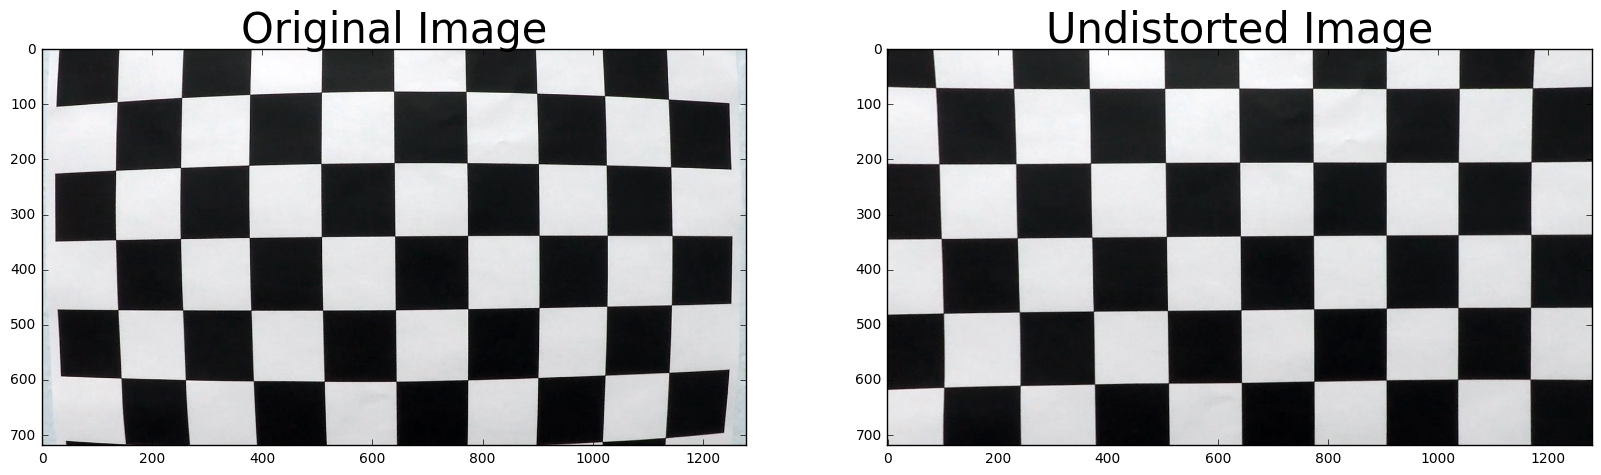

In [2]:
### image info
img_height = 720
img_width = 1280
img_midpoint = img_width // 2
img_size = (img_width, img_height)
ym_per_px = 30 / (img_height)
xm_per_px = 3.7 / (img_width / 3)

### camera calibration
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

cal_images = glob.glob("camera_cal/calibration*.jpg")

for idx, fname in enumerate(cal_images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
orig_cal_img = cv2.imread(cal_images[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

def undistort_image(image):
    undist_image = cv2.undistort(image, mtx, dist, None, mtx)
    
    return undist_image

undist_cal_img = undistort_image(orig_cal_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(orig_cal_img)
ax1.set_title("Original Image", fontsize=30)
ax2.imshow(undist_cal_img)
ax2.set_title("Undistorted Image", fontsize=30)

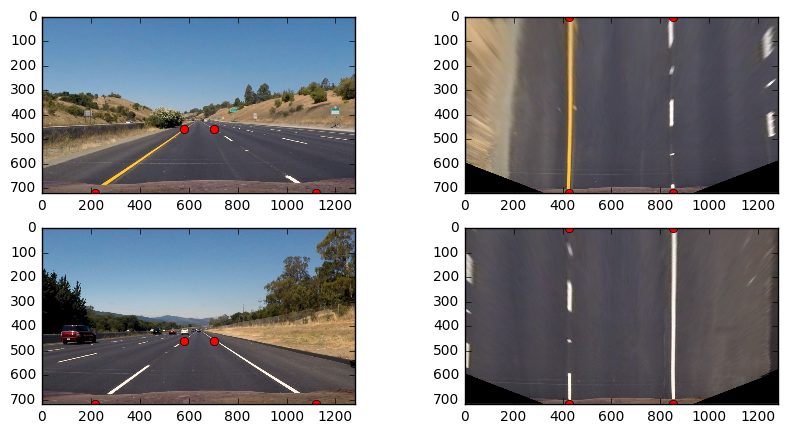

In [3]:
### perspective transform
straight_image_paths = glob.glob("test_images/straight_lines*.jpg")
straight_images = np.array([cv2.imread(path) for path in straight_image_paths])

src_lower_left = [215, 720]
src_upper_left = [580, 460]
src_upper_right = [705, 460]
src_lower_right = [1120, 720]

dst_lower_left = [img_width // 3, img_height]
dst_upper_left = [img_width // 3, 0]
dst_upper_right = [img_width * 2 // 3, 0]
dst_lower_right = [img_width * 2 // 3, img_height]

src_pts = np.float32([src_lower_left, src_upper_left, src_upper_right, src_lower_right])
dst_pts = np.float32([dst_lower_left, dst_upper_left, dst_upper_right, dst_lower_right])

M = cv2.getPerspectiveTransform(src_pts, dst_pts)
Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)

def warp_image(image):
    warped_image = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
        
    return warped_image

def unwarp_image(image):
    unwarped_image = cv2.warpPerspective(image, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return unwarped_image

warped_test_images = np.uint8([warp_image(img) for img in straight_images])

fig = plt.figure(figsize=(10, 5))

for i in range(2):
    fig.add_subplot(2, 2, 2*i+1)
    plt.imshow(straight_images[i,:,:,::-1])
    plt.plot(src_lower_left[0], src_lower_left[1], "ro")
    plt.plot(src_upper_left[0], src_upper_left[1], "ro")
    plt.plot(src_upper_right[0], src_upper_right[1], "ro")
    plt.plot(src_lower_right[0], src_lower_right[1], "ro")
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])
    
    fig.add_subplot(2, 2, 2*i+2)
    plt.imshow(warped_test_images[i,:,:,::-1])
    plt.plot(dst_lower_left[0], dst_lower_left[1], "ro")
    plt.plot(dst_upper_left[0], dst_upper_left[1], "ro")
    plt.plot(dst_upper_right[0], dst_upper_right[1], "ro")
    plt.plot(dst_lower_right[0], dst_lower_right[1], "ro")
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])

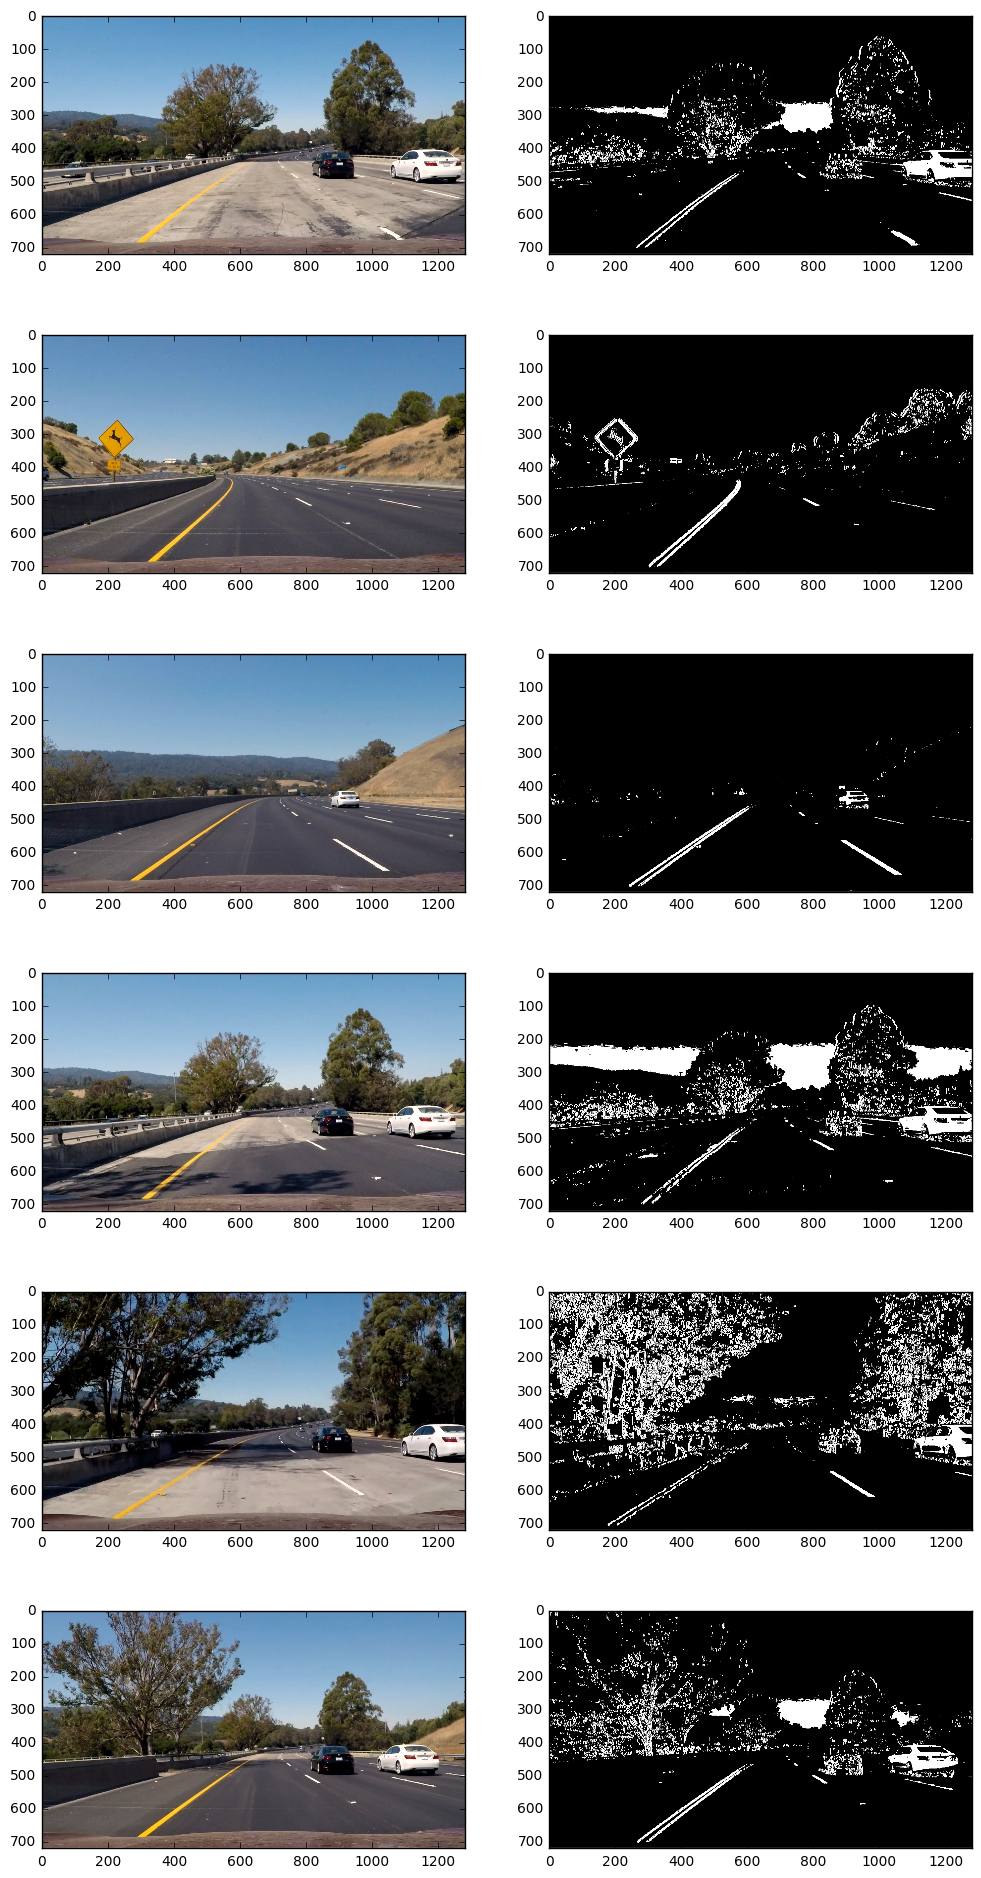

In [4]:
### process images
test_image_paths = glob.glob("test_images/test*.jpg")
test_images = np.array([cv2.imread(path) for path in test_image_paths])

def process(image):
#     yuv_img = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    
#     y_channel = yuv_img[:,:,0]
#     u_channel = yuv_img[:,:,1]
#     v_channel = yuv_img[:,:,2]

#     u_v_diff = u_channel.astype(int) - v_channel.astype(int)
    
#     u_v_diff_binary = np.zeros_like(u_v_diff)
#     u_v_diff_binary[u_v_diff > 30] = 1
#     u_v_diff_binary = np.uint8(u_v_diff_binary)
    
#     y_binary = np.zeros_like(y_channel)
#     y_binary[y_channel > 200] = 1
    
#     combined_binary = np.zeros_like(y_channel)
#     combined_binary[((u_v_diff_binary == 1) | (y_binary == 1))] = 255
    
    hls_img = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    s_channel = hls_img[:,:,2]

    s_x_grad = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=7)
    s_x_grad = np.absolute(s_x_grad)
    s_x_grad = np.uint8(s_x_grad / np.max(s_x_grad) * 255)

    yuv_img = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    y_channel = yuv_img[:,:,0]

    combined_binary = np.zeros_like(y_channel)
    combined_binary[(y_channel >= 200) | (s_x_grad >= 30)] = 255
    
    return combined_binary

processed_images = np.uint8([process(undistort_image(img)) for img in test_images])

fig = plt.figure(figsize=(12, 24))

for i in range(6):
    fig.add_subplot(6, 2, 2*i+1)
    plt.imshow(test_images[i,:,:,::-1])
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])
    
    fig.add_subplot(6, 2, 2*i+2)
    plt.imshow(processed_images[i], cmap="gray")
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])

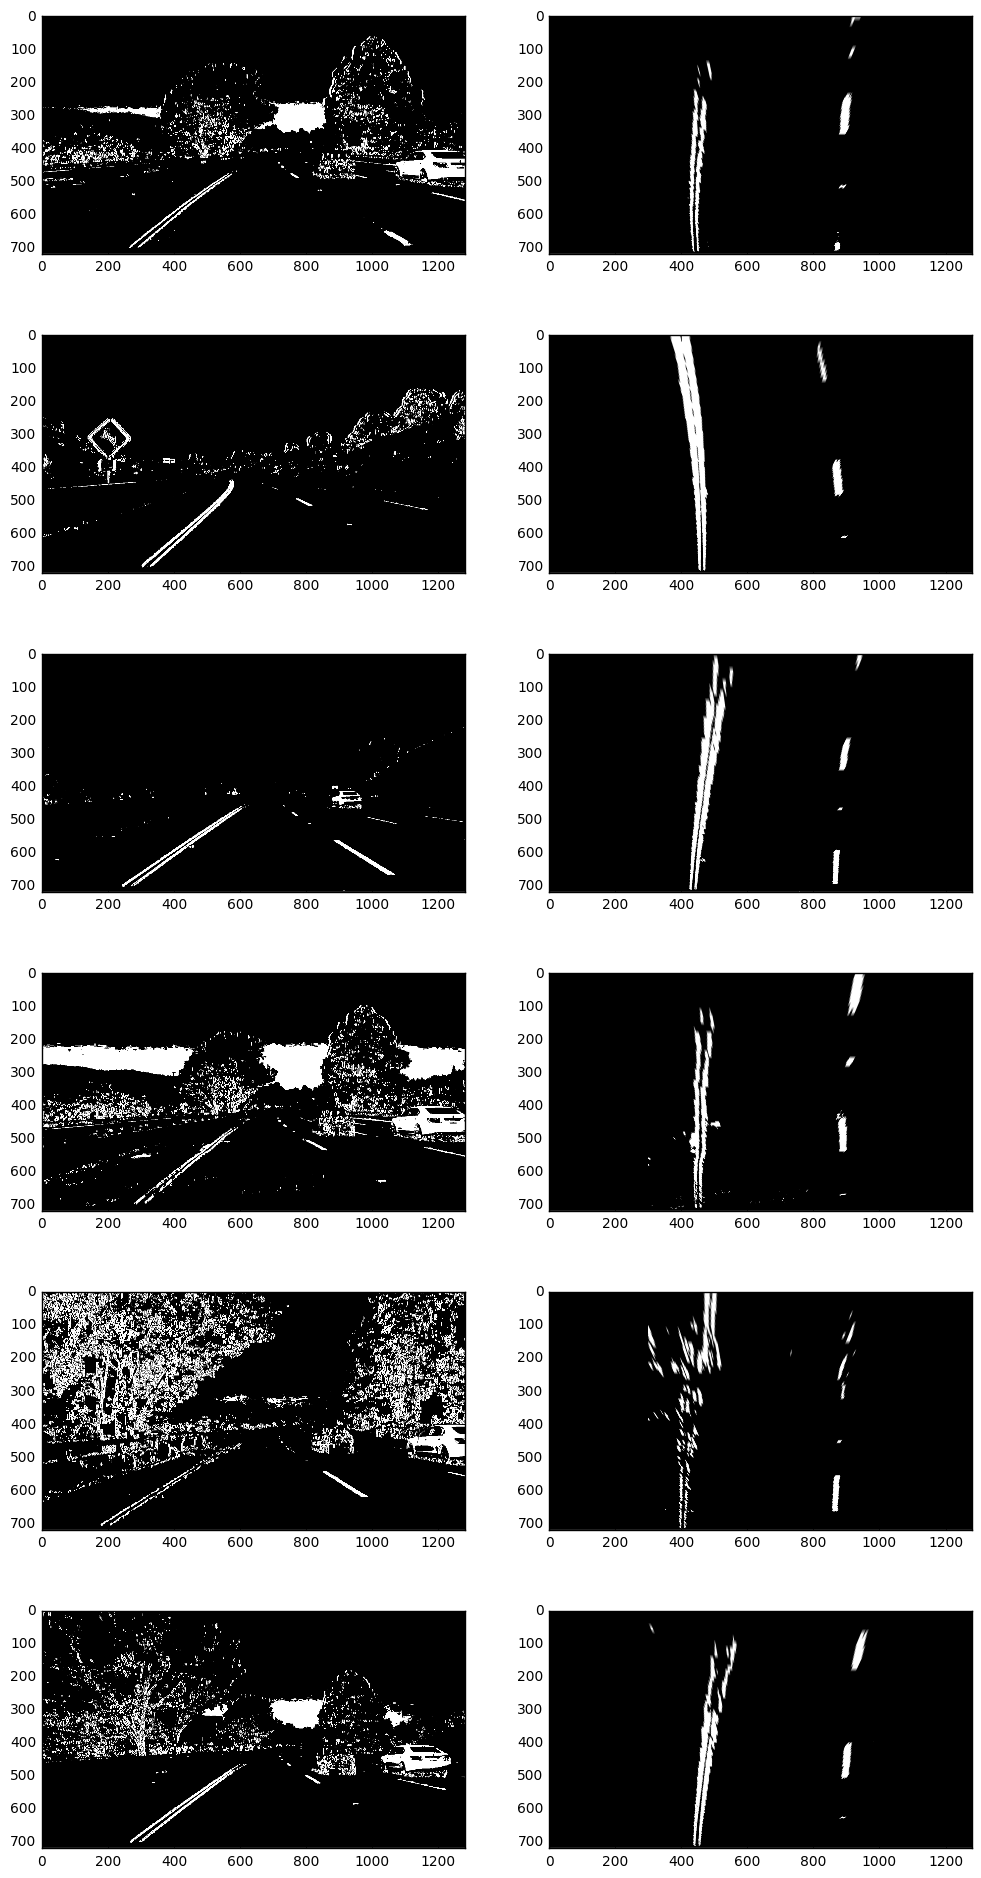

In [5]:
### region mask for warped image
def region_mask(image):
    masked_image = np.copy(image)
    left_margin = 300
    right_margin = 300
    
    masked_image[:,0:left_margin] = 0
    masked_image[:,img_width-right_margin:] = 0
    
    return masked_image

warped_processed_images = np.uint8([warp_image(img) for img in processed_images])
masked_images = np.uint8([region_mask(img) for img in warped_processed_images])

fig = plt.figure(figsize=(12, 24))

for i in range(6):
    fig.add_subplot(6, 2, 2*i+1)
    plt.imshow(processed_images[i], cmap="gray")
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])
    
    fig.add_subplot(6, 2, 2*i+2)
    plt.imshow(masked_images[i], cmap="gray")
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])

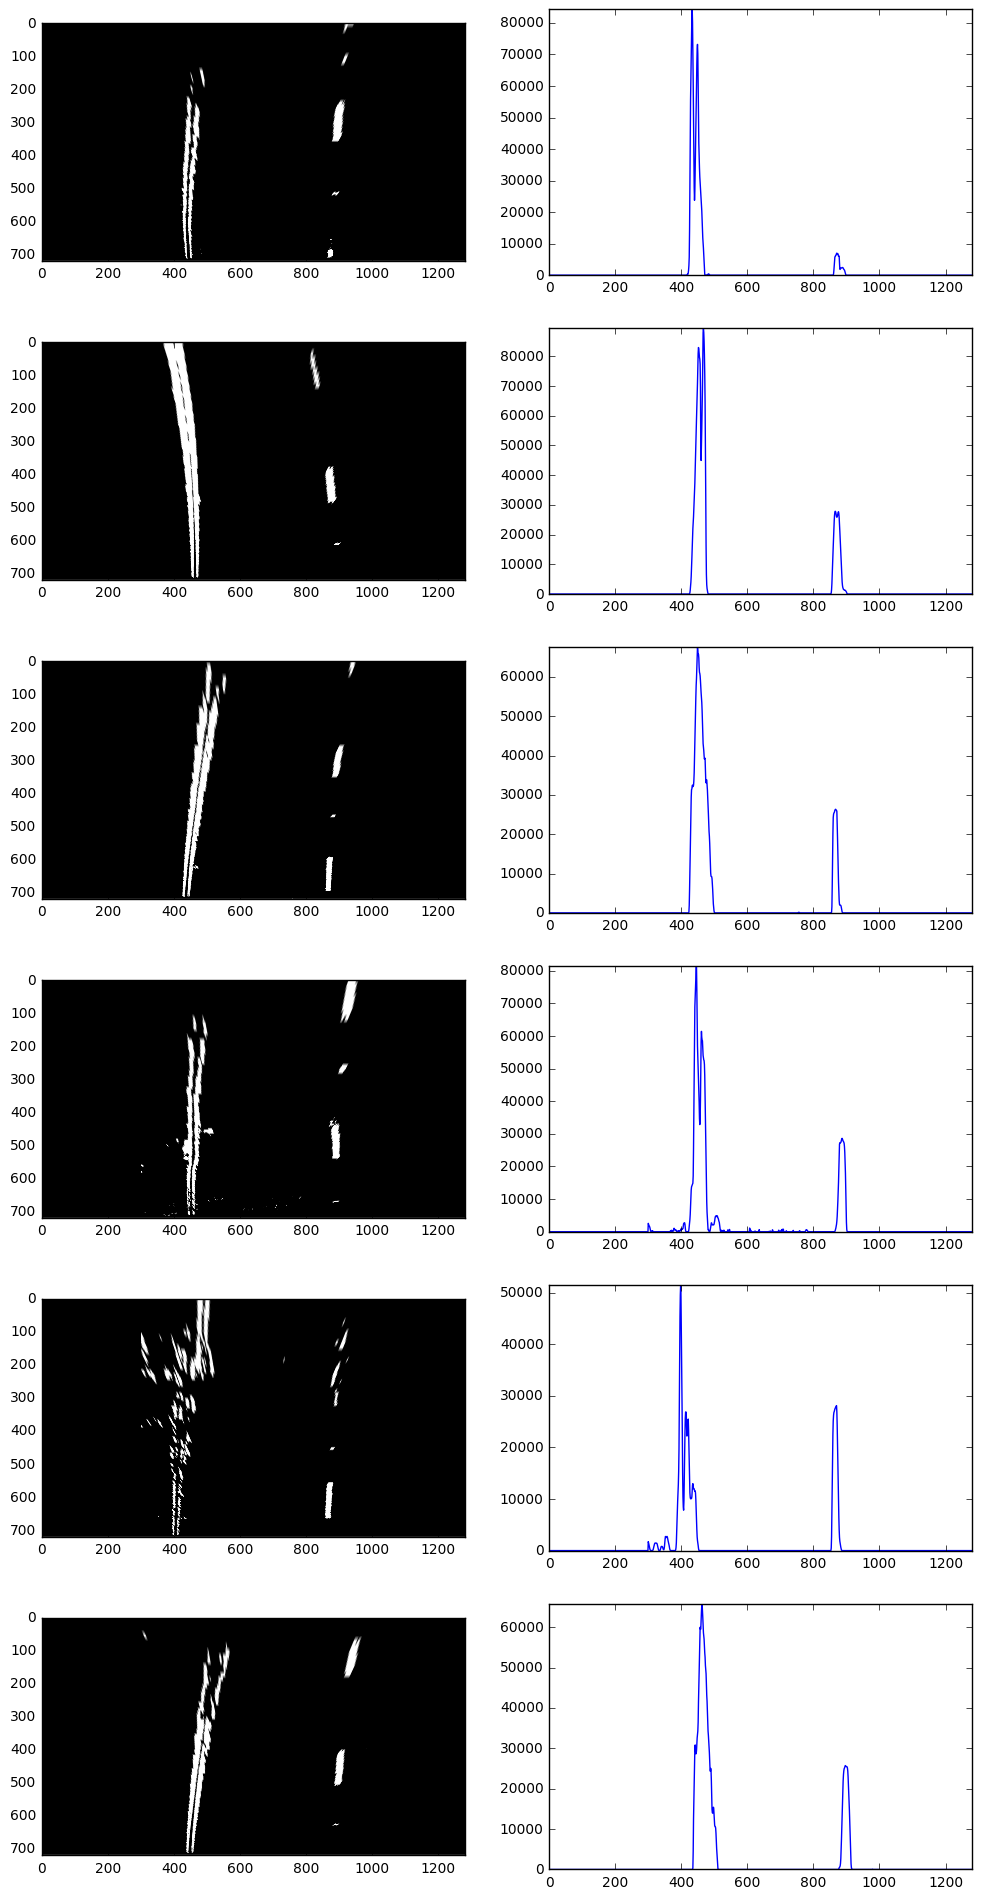

In [6]:
def find_histogram(binary_warped):
    histogram = np.sum(binary_warped[img_height // 2:,:], axis=0)
    
    return histogram

fig = plt.figure(figsize=(12, 24))

for i in range(6):
    fig.add_subplot(6, 2, 2*i+1)
    plt.imshow(masked_images[i], cmap="gray")
    plt.xlim([0, img_width])
    plt.ylim([img_height, 0])
    
    fig.add_subplot(6, 2, 2*i+2)
    histogram = find_histogram(masked_images[i])
    plt.plot(histogram)
    plt.xlim([0, img_width])
    plt.ylim([0, np.max(histogram)])

(720, 0)

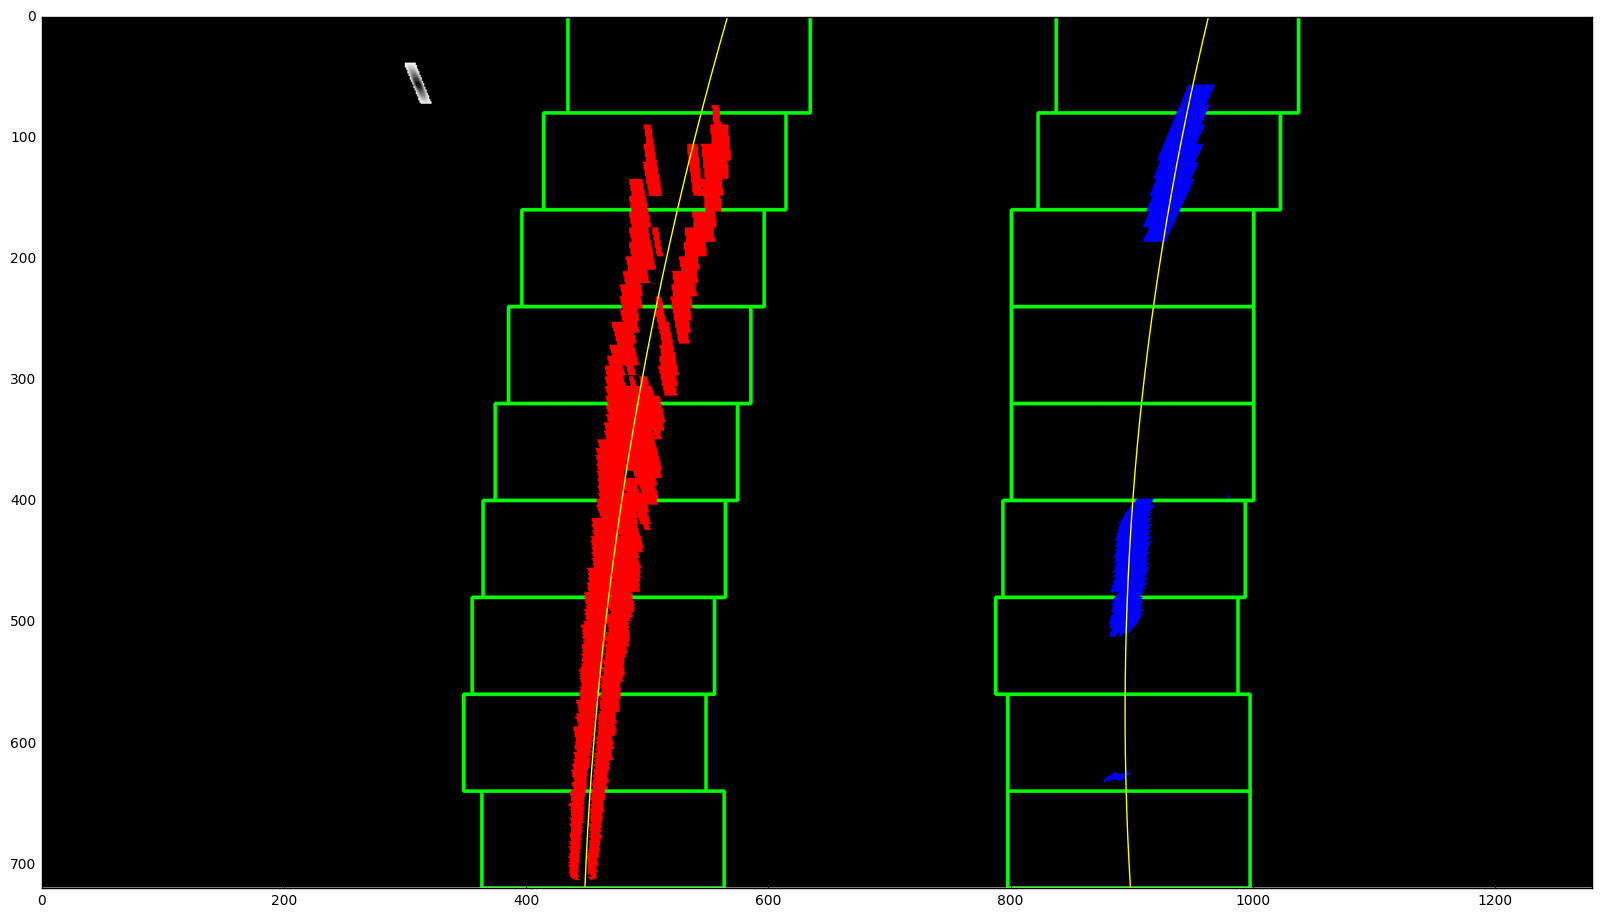

In [7]:
def find_lane_lines_windows(binary_warped):
    highlighted_binary_warped = np.dstack((binary_warped,)*3) * 255
    left_lane_coeff = np.float32([0, 0, 0])
    right_lane_coeff = np.float32([0, 0, 0])
    
    left_win_center = np.argmax(histogram[:img_midpoint])
    right_win_center = np.argmax(histogram[img_midpoint:]) + img_midpoint

    num_windows = 9
    window_height = img_height // num_windows
    
    margin = 100
    minpix = 50
    
    nonzero = binary_warped.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    left_lane_inds = []
    right_lane_inds = []
    
    for win in range(num_windows):
        upper_bound = img_height - win * window_height
        lower_bound = upper_bound - window_height
        
        left_lane_left_bound = left_win_center - margin
        left_lane_right_bound = left_win_center + margin
        
        right_lane_left_bound = right_win_center - margin
        right_lane_right_bound = right_win_center + margin
        
        cv2.rectangle(highlighted_binary_warped,(left_lane_left_bound,lower_bound),(left_lane_right_bound,upper_bound),(0,255,0), 2) 
        cv2.rectangle(highlighted_binary_warped,(right_lane_left_bound,lower_bound),(right_lane_right_bound,upper_bound),(0,255,0), 2) 
        
        left_win_inds = ((nonzerox >= left_lane_left_bound)
                            & (nonzerox <= left_lane_right_bound)
                            & (nonzeroy >= lower_bound)
                            & (nonzeroy <= upper_bound)).nonzero()[0]
        
        right_win_inds = ((nonzerox >= right_lane_left_bound)
                            & (nonzerox <= right_lane_right_bound)
                            & (nonzeroy >= lower_bound)
                            & (nonzeroy <= upper_bound)).nonzero()[0]
        
        if len(left_win_inds) > minpix:
            left_win_center = np.mean(nonzerox[left_win_inds]).astype(np.int)
        if len(right_win_inds) > minpix:
            right_win_center = np.mean(nonzerox[right_win_inds]).astype(np.int)
        
        left_lane_inds.append(left_win_inds)
        right_lane_inds.append(right_win_inds)
        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    left_lane_x = nonzerox[left_lane_inds]
    left_lane_y = nonzeroy[left_lane_inds]
    
    right_lane_x = nonzerox[right_lane_inds]
    right_lane_y = nonzeroy[right_lane_inds]
    
    highlighted_binary_warped[left_lane_y, left_lane_x] = [255, 0, 0]
    highlighted_binary_warped[right_lane_y, right_lane_x] = [0, 0, 255]
    
    left_lane_coeff_px = np.polyfit(left_lane_y, left_lane_x, 2)
    right_lane_coeff_px = np.polyfit(right_lane_y, right_lane_x, 2)
    
    left_lane_coeff_m = np.polyfit(left_lane_y * ym_per_px, left_lane_x * xm_per_px, 2)
    right_lane_coeff_m = np.polyfit(right_lane_y * ym_per_px, right_lane_x * xm_per_px, 2)
    
    return highlighted_binary_warped, left_lane_coeff_px, right_lane_coeff_px, left_lane_coeff_m, right_lane_coeff_m

highlighted_binary_warped, left_lane_coeff_px, right_lane_coeff_px, left_lane_coeff_m, right_lane_coeff_m = find_lane_lines_windows(masked_images[5])

fig = plt.figure(figsize=(20, 40))
plt.imshow(highlighted_binary_warped)

plot_y = np.linspace(0, img_height, img_height+1)

left_plot_x = left_lane_coeff_px[0] * plot_y**2 + left_lane_coeff_px[1] * plot_y + left_lane_coeff_px[2]
right_plot_x = right_lane_coeff_px[0] * plot_y**2 + right_lane_coeff_px[1] * plot_y + right_lane_coeff_px[2]

plt.plot(left_plot_x, plot_y, color="yellow")
plt.plot(right_plot_x, plot_y, color="yellow")
plt.xlim(0, img_width)
plt.ylim(img_height, 0)

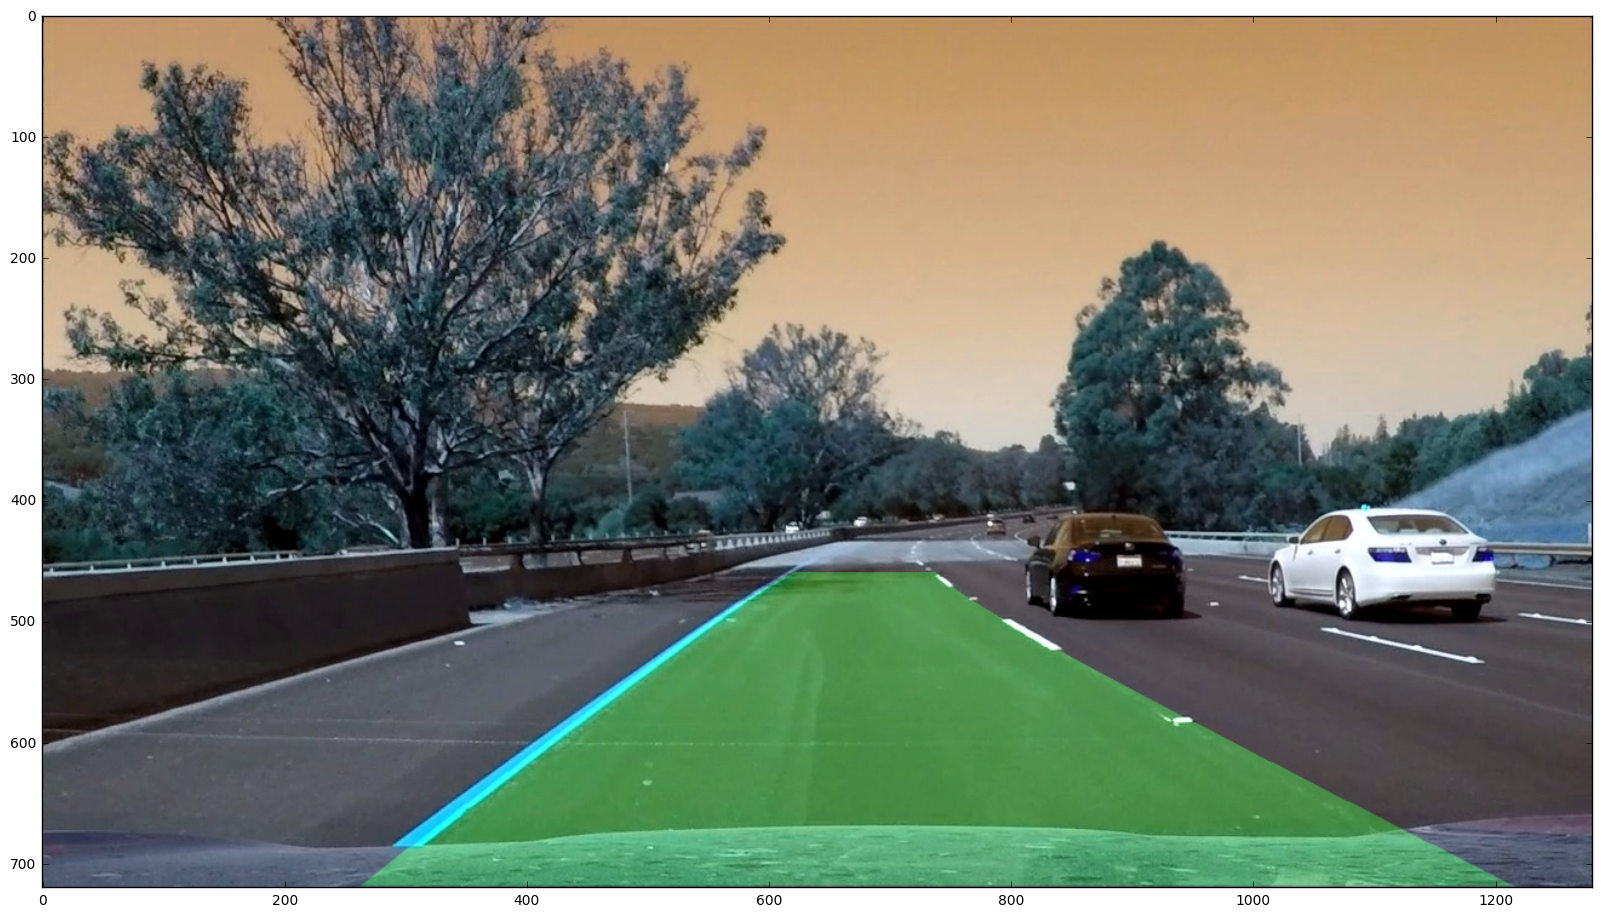

In [8]:
def fill_lane(orig_image, left_lane_coeff_px, right_lane_coeff_px):
    fill_image = np.zeros_like(orig_image)

    plot_y = np.linspace(0, img_height, img_height+1)
    
    left_plot_x = left_lane_coeff_px[0] * plot_y**2 + left_lane_coeff_px[1] * plot_y + left_lane_coeff_px[2]
    right_plot_x = right_lane_coeff_px[0] * plot_y**2 + right_lane_coeff_px[1] * plot_y + right_lane_coeff_px[2]
    
    left_poly_points = np.vstack((left_plot_x, plot_y)).T
    right_poly_points = np.vstack((right_plot_x, plot_y)).T
    right_poly_points = np.flipud(right_poly_points)
    
    poly_points = np.vstack((left_poly_points, right_poly_points))
    poly_points = np.expand_dims(poly_points, axis=0).astype(np.int_)

    cv2.fillPoly(fill_image, poly_points, (0, 255, 0))
    fill_image = unwarp_image(fill_image)
    
    fill_lane_image = cv2.addWeighted(orig_image, 1, fill_image, 0.3, 0)

    return fill_lane_image

filled_lane = fill_lane(test_images[5], left_lane_coeff_px, right_lane_coeff_px)
fig = plt.figure(figsize=(20, 40))
plt.imshow(filled_lane)

In [87]:
def curve_radius(left_lane_coeff_m, right_lane_coeff_m):
    ym = img_height * ym_per_px

    left_curve_rad_m = (1 + (2 * left_lane_coeff_m[0] * ym + left_lane_coeff_m[1])**2)**1.5 / np.absolute(2 * left_lane_coeff_m[0])
    right_curve_rad_m = (1 + (2 * right_lane_coeff_m[0] * ym + right_lane_coeff_m[1])**2)**1.5 / np.absolute(2 * right_lane_coeff_m[0])
    
    curve_radius_m = (left_curve_rad_m + right_curve_rad_m) / 2
    
    return curve_radius_m

def off_center(left_lane_coeff_px, right_lane_coeff_px):
    y = img_height
    leftx = left_lane_coeff_px[0] * y**2 + left_lane_coeff_px[1] * y + left_lane_coeff_px[2]
    rightx = right_lane_coeff_px[0] * y**2 + right_lane_coeff_px[1] * y + right_lane_coeff_px[2]
    
    lane_midpoint = (leftx + rightx) / 2
    off_center_px = img_midpoint - lane_midpoint
    
    off_center_m = off_center_px * xm_per_px
    
    return off_center_m

def add_stats(image, curve_radius_m, off_center_m):
    curve_radius_text = "Curve radius: {} m".format(int(curve_radius_m))
    off_center_text = "Off center: {:.2f} m".format(off_center_m)
    
    cv2.putText(image, curve_radius_text, (200,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
    cv2.putText(image,off_center_text, (200,200), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 3)
    
    return image

In [88]:
### helper function (useful sometimes)
def expand_dim(image):
    exp_image = np.dstack((image,)*3)
    return exp_image

curve_radii = []
frame_num = 0

### pipeline
def pipeline(image):
    undist_image = undistort_image(image)
    processed_image = process(undist_image)
    warped_image = warp_image(processed_image)
    masked_image = region_mask(warped_image)
    highlighted_binary_warped, left_lane_coeff_px, right_lane_coeff_px, left_lane_coeff_m, right_lane_coeff_m = find_lane_lines_windows(masked_image)
    curve_radius_m = curve_radius(left_lane_coeff_m, right_lane_coeff_m)
    if curve_radius_m < 5000 and curve_radius_m > 200:
        curve_radii.append(curve_radius_m)

    off_center_m = off_center(left_lane_coeff_px, right_lane_coeff_px)
    filled_lane = fill_lane(undist_image, left_lane_coeff_px, right_lane_coeff_px)
    
    if frame_num % 24 == 0:
        disp_curve_rad = np.mean(curve_radii[-20:])

    output = add_stats(filled_lane, disp_curve_rad, off_center_m)

    return output

In [89]:
output_video = 'output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [01:51<00:00, 11.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 2min 28s, sys: 27 s, total: 2min 55s
Wall time: 1min 52s


In [90]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

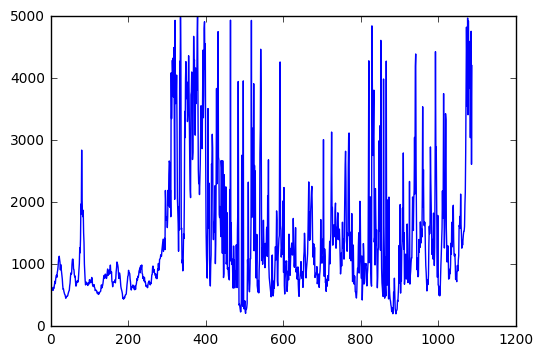

In [91]:
foo = np.array(foo)
bar = np.copy(foo)

bar[(foo > 5000) | (foo < 100)]  = 0

plt.plot(bar[bar.nonzero()[0]])

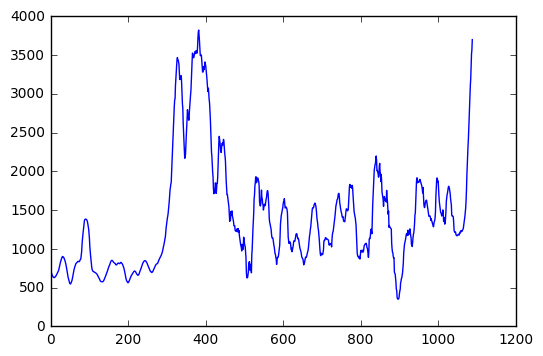

In [92]:
plt.plot(floopdidoo)

In [93]:
print(floopdidoo)

[1000, 692.70794527640112, 692.70794527640112, 671.71026215754557, 659.74916141499045, 650.48517592850499, 641.71470266690665, 633.00012687825017, 632.44913513366623, 630.02091737784406, 631.08541479266955, 635.56744294617124, 643.34098860412587, 647.05792688848908, 655.5601346420782, 665.79992687756237, 675.91230372565428, 682.79751486396538, 693.20235020357529, 704.30182223341592, 716.99358746618168, 734.87468329132412, 755.40343379223236, 780.52896259580677, 803.80452890590982, 824.89344604374469, 840.65266646586792, 861.49411075638659, 876.80775861558993, 889.50483123887386, 898.55324301079509, 902.69769123125695, 899.49027300860837, 894.91654536191731, 886.92721042271444, 874.87066479333203, 860.80309274329591, 847.08381935049113, 829.1590690084447, 808.08947415644377, 782.88890400382729, 753.92711849920784, 723.07313274509443, 690.59974107055973, 660.53546905654605, 633.65844872621722, 614.37632607594128, 591.89696876379594, 573.66773782696839, 559.45944207752063, 551.10096145645